In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error as mae

## Load Dataset

In [3]:
data = pd.read_csv("/content/drive/MyDrive/Projects/Zillow Home Value Prediction/Zillow.csv")
data.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,target
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0.025595
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,0.055619
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,0.005383
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,-0.103410
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,73681.0,119407.0,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,0.006940


In [4]:
data.shape

(77613, 59)

## Data Cleaning

In [5]:
# Remove columns with only one unique value or more than 60% nulls
to_remove = [col for col in data.columns if data[col].nunique() == 1 or data[col].isnull().mean() > 0.6]
print(f"Columns to remove: {len(to_remove)}")
data.drop(to_remove, axis=1, inplace=True)

# Fill missing values: mean for numerics, mode for categoricals
for col in data.columns:
    if data[col].dtype == "object":
        data[col] = data[col].fillna(data[col].mode()[0])
    else:
        data[col] = data[col].fillna(data[col].mean())

print(f"Remaining missing values: {data.isnull().sum().sum()}")

Columns to remove: 30
Remaining missing values: 0


## Exploratory Data Analysis (EDA)

In [6]:
# Count column types
ints = [col for col in data.columns if data[col].dtype == int]
floats = [col for col in data.columns if data[col].dtype == float]
objects = [col for col in data.columns if data[col].dtype == object]
print(f"Ints: {len(ints)}, Floats: {len(floats)}, Objects: {len(objects)}")

Ints: 1, Floats: 26, Objects: 2


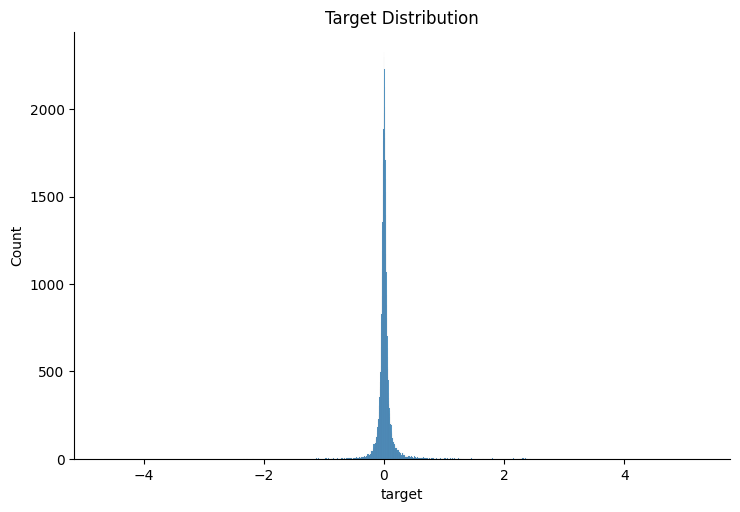

In [7]:
# Target distribution
sns.displot(data["target"], height=5, aspect=1.5)
plt.title("Target Distribution")
plt.show()

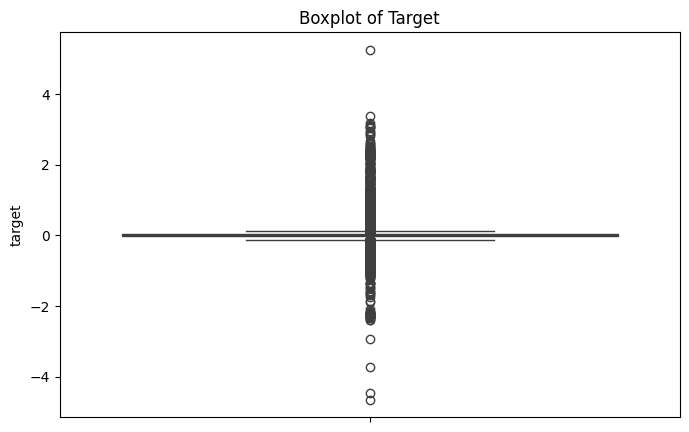

In [8]:
# Detect outliers with boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data["target"])
plt.title("Boxplot of Target")
plt.show()

## Outlier Removal

In [9]:
print('Shape of the dataframe before removal of outliers', data.shape)
data = data[(data["target"] > -1) & (data["target"] < 1)]
print('Shape of the dataframe after removal of outliers ', data.shape)

Shape of the dataframe before removal of outliers (77613, 29)
Shape of the dataframe after removal of outliers  (77261, 29)


## Encode Categorical Features

In [10]:
for col in objects:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

## Correlation Heatmap

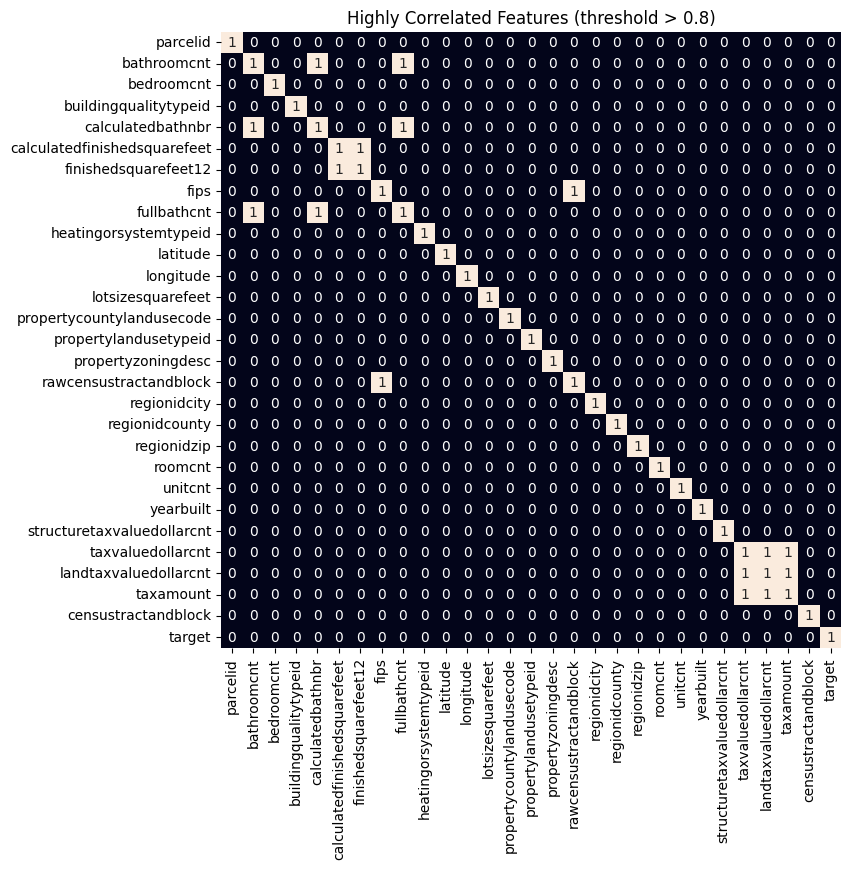

In [11]:
plt.figure(figsize=(8, 8))
sns.heatmap(data.corr() > 0.8, annot=True, cbar=False)
plt.title("Highly Correlated Features (threshold > 0.8)")
plt.show()

## Drop Highly Correlated Columns

In [12]:
to_remove = ['calculatedbathnbr', 'fullbathcnt', 'fips',
             'rawcensustractandblock', 'taxvaluedollarcnt',
             'finishedsquarefeet12', 'landtaxvaluedollarcnt']

data.drop(to_remove, axis=1, inplace=True)

## Model Training and Evaluation

In [13]:
X = data.drop(["parcelid", "target"], axis=1).values
y = data["target"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)

Train shape: (61808, 20) | Test shape: (15453, 20)


In [14]:
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
models = [LinearRegression(), XGBRegressor(), Lasso(), Ridge()]

for model in models:
    model.fit(X_train, y_train)

    print(f"{model.__class__.__name__} results:")
    print(f"  Train MAE: {mae(y_train, model.predict(X_train)):.4f}")
    print(f"  Test MAE : {mae(y_test, model.predict(X_test)):.4f}\n")

LinearRegression results:
  Train MAE: 0.0621
  Test MAE : 0.0630

XGBRegressor results:
  Train MAE: 0.0562
  Test MAE : 0.0652

Lasso results:
  Train MAE: 0.0621
  Test MAE : 0.0629

Ridge results:
  Train MAE: 0.0621
  Test MAE : 0.0630

